In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from nnAudio.Spectrogram import CQT1992v2
from torch.utils.data import DataLoader, Dataset
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from functools import partial

In [2]:
import sys
sys.path.insert(0, "../")
from src.model import CustomModel_v1, Andrewnet_v3_true
from src.dataset import TrainDataset
from src.transforms import stack_bandpass_transform, stack_bandpass_turkey_transform, stack_turkey

In [3]:
INPUT_PATH = Path("/home/trytolose/rinat/kaggle/grav_waves_detection/input")

In [4]:
import torch
import torch.nn as nn
import timm

class CustomModel_v1(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.model = timm.create_model("efficientnet_b0", pretrained=pretrained, in_chans=3, num_classes=1)
        self.cqt = CQT1992v2(**cfg.qtransform_params)
        self.h, self.w = 256, 256

    def forward(self, x):
        bs, ch, sig_len = x.shape
        x = x.view(-1, sig_len)
        x = self.cqt(x).unsqueeze(1)
        x = nn.functional.interpolate(x, (self.h, self.w))
        _, _, h, w = x.shape
        x = x.view(bs, 3, h, w)
        output = self.model(x)
        return output


In [5]:
class CFG:
    def __init__(self):
        self.qtransform_params = {
            'sr': 2048,
            'fmin': 20,
            'fmax': 1024,
            'hop_length': 32,
            'bins_per_octave': 8,
        }

        self.bandpass_param = {
          'lf': 30,
          'hf': 400,
          'order': 8, 
          'sr': 2048,
        }
cfg = CFG()

In [6]:
df = pd.read_csv(INPUT_PATH / "sample_submission.csv")

files = list((INPUT_PATH / "test").rglob("*.npy"))
FILE_PATH_DICT = {x.stem: str(x) for x in files}
df["path"] = df["id"].apply(lambda x: FILE_PATH_DICT[x])

In [7]:
!ls -lt ../weights

total 695368
-rw-rw-r-- 1 trytolose trytolose   2560697 Aug 28 18:11 wavenet_fold_0_w.pt
-rw-rw-r-- 1 trytolose trytolose  17082923 Aug 28 13:00 cos_bandpass_minmax_fold_0_w.pt
-rw-rw-r-- 1 trytolose trytolose  16697067 Aug 28 10:39 stack_turkey_q_fold_0_w.pt
-rw-rw-r-- 1 trytolose trytolose  16697067 Aug 28 10:39 stack_bandpass_turkey_transform_q_fold_4_w.pt
-rw-rw-r-- 1 trytolose trytolose  16697067 Aug 28 10:39 stack_bandpass_turkey_transform_q_fold_3_w.pt
-rw-rw-r-- 1 trytolose trytolose  16697067 Aug 28 10:39 stack_bandpass_turkey_transform_q_fold_2_w.pt
-rw-rw-r-- 1 trytolose trytolose  16697067 Aug 28 10:39 stack_bandpass_turkey_transform_q_fold_1_w.pt
-rw-rw-r-- 1 trytolose trytolose  16697067 Aug 28 10:39 stack_bandpass_turkey_transform_q_fold_0_w.pt
-rw-rw-r-- 1 trytolose trytolose  16327345 Aug 28 10:39 stack_bandpass_turkey_transform_cwt_fold_0_w.pt
-rw-rw-r-- 1 trytolose trytolose  16697067 Aug 28 10:39 stack_bandpass_transform_q_fold_0_w.pt
-rw-rw-r-- 1 trytolose trytolos

In [8]:
# model = CustomModel_v1(cfg).cuda()
model = Andrewnet_v3_true().cuda()
transform_f = partial(stack_bandpass_transform, params=cfg.bandpass_param)
val_ds = TrainDataset(
    df,
    mode="test",
    transform=transform_f,
)
val_loader = DataLoader(val_ds, shuffle=False, num_workers=12, batch_size=128, pin_memory=False)
total_predicts = []
for f in range(1):
#     model.load_state_dict(torch.load(f"../weights/cos_bandpass_minmax_fold_{f}_w.pt"))
    model.load_state_dict(torch.load(f"../weights/wavenet_fold_{f}_w.pt"))
    val_pred = []
    model.eval()
    with torch.no_grad():
        for x in tqdm(val_loader, ncols=50, leave=True):
            x = x.cuda().float()
            pred = model(x)
            pred = pred.sigmoid().cpu().data.numpy()
            val_pred.append(pred)
            
    val_pred = np.concatenate(val_pred).reshape(-1,)
    total_predicts.append(val_pred)

100%|█████████| 1766/1766 [03:42<00:00,  7.95it/s]


In [9]:
total_predicts = np.stack(total_predicts)

In [10]:
total_predicts.shape

(1, 226000)

In [11]:
df['target'] = total_predicts[0] #.mean(axis=0)

In [12]:
df = df.drop("path", axis=1)

In [13]:
df

,id,target
0,00005bced6,0.999062
1,0000806717,0.959905
2,0000ef4fe1,0.253698
3,00020de251,0.404031
4,00024887b5,0.196941
...,...,...
225995,ffff4125f1,0.409374
225996,ffff9d32a6,0.440559
225997,ffff9f4c1f,0.260817
225998,ffffa19693,0.999905


In [14]:
df.to_csv("submission_wave.csv", index=False)

In [16]:
df_cnn = pd.read_csv("submission.csv")

In [20]:
df_blend = df.copy()

In [25]:
df_blend['target'] = 0.3* df['target'] + 0.7*df_cnn['target']
df_blend.to_csv("submission_blend.csv", index=False)

In [26]:
!kaggle competitions submit -c g2net-gravitational-wave-detection -f submission_blend.csv -m "3ch bandpass minmax wavenet effnet blend 0.4 0.6 fold#0"

100%|██████████████████████████████████████| 6.53M/6.53M [00:05<00:00, 1.17MB/s]
Successfully submitted to G2Net Gravitational Wave Detection

In [ ]:
df_top_fp=df[df['target']==0].sort_values("target_pred", ascending=False)[:10]
df_top_fp.to_csv("top_10_fp.csv", index=False)

In [ ]:
df_min = df.sort_values("target_pred")[:10].copy()
df_max = df.sort_values("target_pred", ascending=False)[:10].copy()

In [ ]:
df_max

In [ ]:
df_total = pd.concat([df_max, df_min], ignore_index=True)
df_total.to_csv("top_min_max.csv", index=False)

In [ ]:
!nvidia-smi

In [4]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [40]:
from torch.optim import Adam
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR
import matplotlib.pyplot as plt

model = models.resnet18()
optimizer = Adam(model.parameters(), lr=0.001)

In [49]:
lrs = [0.001]

# scheduler = CosineAnnealingWarmRestarts(optimizer, 5, 1)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

for epoch in range(10):
    for i in range(3500):
        optimizer.step()
        scheduler.step(epoch + i / 3500)
        lrs.append(get_lr(optimizer))

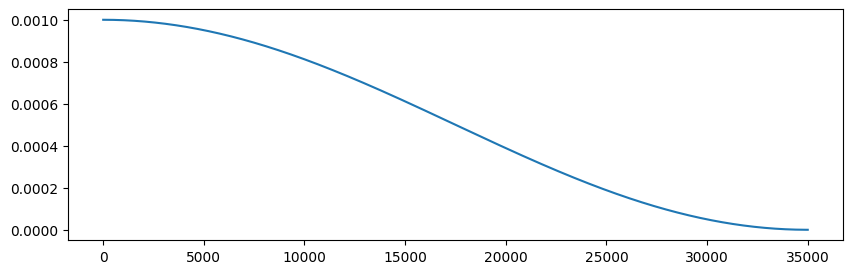

In [50]:
plt.figure(figsize=(10,3))
plt.plot(lrs)
plt.show()